### MC Directory Edits

# ADS-508-01-SP23 Team 8: Final Project

# Setup Database and Athena Tables

Much of the code is modified from `Fregly, C., & Barth, A. (2021). Data science on AWS: Implementing end-to-end, continuous AI and machine learning pipelines. O’Reilly.`

## Install missing dependencies

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [33]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
!pip install missingno

## Globally import libraries

In [32]:
import boto3
from botocore.client import ClientError
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
from pyathena import connect
import matplotlib.pyplot as plt
import missingno as msno
import sagemaker
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats import skew

## Instantiate AWS SageMaker session

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
def_bucket = sagemaker_session.default_bucket()
bucket = 't8-test-final'

# bucket is the 'public' bucket where the datasets have been uploaded to. In previous versions bucket = sagemaker-us-east-ads508-sp23-t8

s3 = boto3.Session().client(service_name="s3",
                            region_name=region)

role = sagemaker.get_execution_role()
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker",
                            region_name=region)

In [5]:
setup_s3_bucket_passed = False
ingest_create_athena_db_passed = False
ingest_create_athena_table_tsv_passed = False

In [6]:
print(f"Default bucket: {def_bucket}")
print(f"Public T8 bucket: {bucket}")

Default bucket: sagemaker-us-east-1-122149314005
Public T8 bucket: t8-test-final


## Verify S3 Bucket Creation

In [7]:
%%bash

aws s3 ls s3://${bucket}/

2023-03-18 20:53:08 aws-athena-query-results-122149314005-us-east-1
2023-03-05 21:53:59 sagemaker-studio-122149314005-sw16ud198bb
2023-03-05 21:59:02 sagemaker-us-east-1-122149314005
2023-03-19 21:18:45 t8-mc-access
2023-03-23 20:28:25 t8-test-final


In [8]:
response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print(f"[ERROR] Cannot find bucket {bucket} in {response} due to {e}.")

{'ResponseMetadata': {'RequestId': 'PCVNP0MXCVJH6KZ9', 'HostId': 'zinpf5KAXv4+Tke0jmaVjKL5A7m36bYoJPu0dfxIC0Z/qDfuY0yccisgBZe/hOBg4qEkXEP+w04=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'zinpf5KAXv4+Tke0jmaVjKL5A7m36bYoJPu0dfxIC0Z/qDfuY0yccisgBZe/hOBg4qEkXEP+w04=', 'x-amz-request-id': 'PCVNP0MXCVJH6KZ9', 'date': 'Sun, 26 Mar 2023 01:08:43 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}}


In [9]:
%store setup_s3_bucket_passed

Stored 'setup_s3_bucket_passed' (bool)


# Set S3 Source Location (Public S3 Bucket)

In [10]:
s3_public_path_tsv = f"s3://{bucket}"

In [11]:
%store s3_public_path_tsv

Stored 's3_public_path_tsv' (str)


# Set S3 Destination Location (Our Private S3 Bucket)

In [13]:
s3_private_path_tsv = f"s3://{def_bucket}/team_8_data"
print(s3_private_path_tsv)

#this is where the data from the source bucket is copied into. 

s3://sagemaker-us-east-1-122149314005/team_8_data


In [14]:
%store s3_private_path_tsv

Stored 's3_private_path_tsv' (str)


# Copy Data From the Public S3 Bucket to our Private S3 Bucket in this Account
As the full dataset is pretty large, let's just copy 3 files into our bucket to speed things up later. 

In [14]:
#!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/

copy: s3://t8-test-final/raw_data/census/nyc_census_tracts.csv to s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/census/nyc_census_tracts.csv
copy: s3://t8-test-final/raw_data/grad_outcomes/2005-2010_Graduation_Outcomes_-_School_Level.tsv to s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/grad_outcomes/2005-2010_Graduation_Outcomes_-_School_Level.tsv
copy: s3://t8-test-final/raw_data/hs_dir/2014_-_2015_DOE_High_School_Directory.tsv to s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/hs_dir/2014_-_2015_DOE_High_School_Directory.tsv
copy: s3://t8-test-final/raw_data/evictions/Evictions.tsv to s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/evictions/Evictions.tsv
copy: s3://t8-test-final/raw_data/jobs/NYC_Jobs.tsv to s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/jobs/NYC_Jobs.tsv


# _Make sure ^^^^ this ^^^^ S3 COPY command above runs succesfully. We will need those datafiles for the rest of this workshop._

# List Files in our Private S3 Bucket in this Account

In [15]:
print(s3_private_path_tsv)

s3://sagemaker-us-east-1-122149314005/team_8_data


In [16]:
!aws s3 ls $s3_private_path_tsv/

                           PRE athena/
                           PRE columnar/
                           PRE raw_data/


In [17]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/amazon-reviews-pds/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

## Create Athena Database

In [18]:
database_name = "ads508_t8"

Note: The databases and tables that we create in Athena use a data catalog service to store the metadata of your data. For example, schema information consisting of the column names and data type of each column in a table, together with the table name, is saved as metadata information in a data catalog. 

Athena natively supports the AWS Glue Data Catalog service. When we run `CREATE DATABASE` and `CREATE TABLE` queries in Athena with the AWS Glue Data Catalog as our source, we automatically see the database and table metadata entries being created in the AWS Glue Data Catalog.

In [19]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = f"s3://{def_bucket}/athena/staging"
print(s3_staging_dir)

s3://sagemaker-us-east-1-122149314005/athena/staging


In [20]:
conn = connect(region_name=region,
               s3_staging_dir=s3_staging_dir)

In [21]:
create_db_stmnt = f"CREATE DATABASE IF NOT EXISTS {database_name}"
print(create_db_stmnt)

CREATE DATABASE IF NOT EXISTS ads508_t8


In [22]:
pd.read_sql(create_db_stmnt,
            conn)

""


### Verify The Database Has Been Created Succesfully

In [23]:
show_db_stmnt = "SHOW DATABASES"

df_show = pd.read_sql(show_db_stmnt,
                      conn)
df_show.head(17)

,database_name
0,ads508_t8
1,ads508_t8_mc_test
2,default
3,dsoaws
4,dsoaws1
5,t8_test


In [24]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [25]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


## Define custom function to create tables in existing database

In [26]:
def create_athena_tbl_tsv(conn=None,
                          db=None,
                          tbl_name=None,
                          fields='',
                          s3_path=None,
                          delim=',',
                          ret='',
                          comp='',
                          skip=''):
    # Set Athena parameters

    # SQL statement to execute
    drop_tsv_tbl_stmnt = f"""DROP TABLE IF EXISTS {db}.{tbl_name}"""

    create_tsv_tbl_stmnt = f"""
        CREATE EXTERNAL TABLE IF NOT EXISTS {db}.{tbl_name}({fields})
        ROW FORMAT DELIMITED
            FIELDS
                TERMINATED BY '{delim}'
            LINES
                TERMINATED BY '{ret}\\n'
        LOCATION '{s3_path}'
        TBLPROPERTIES ({comp}{skip})
        """

    print(f'Create table statement:\n{create_tsv_tbl_stmnt}')

    pd.read_sql(drop_tsv_tbl_stmnt,
                conn)

    pd.read_sql(create_tsv_tbl_stmnt,
                conn)
    
    # Verify The Table Has Been Created Succesfully
    show_tsv_tbl_stmnt = f"SHOW TABLES IN {db}"

    df_show = pd.read_sql(show_tsv_tbl_stmnt,
                          conn)
    display(df_show.head(17))

    if tbl_name in df_show.values:
        ingest_create_athena_table_tsv_passed = True

    print(f'\nDataframe contains records: {ingest_create_athena_table_tsv_passed}')

## Create Athena Table from Local TSV File - `2005-2010_Graduation_Outcomes_-_School_Level.tsv`

### Dataset columns

- `demographic`: ,
- `dbn`: ,
- `school_name`: ,
- `cohort`: ,
- `total_cohort`: ,
- `total_grads_n`: ,
- `total_grads_perc_cohort`: ,
- `total_regents_n`: ,
- `total_regents_perc_cohort`: ,
- `total_regents_perc_grads`: ,
- `advanced_regents_n`: ,
- `advanced_regents_perc_cohort`: ,
- `advanced_regents_perc_grads`: ,
- `regents_wo_advanced_n`: ,
- `regents_wo_advanced_perc_cohort`: ,
- `regents_wo_advanced_perc_grads`: ,
- `local_n`: ,
- `local_perc_cohort`: ,
- `local_perc_grads`: ,
- `still_enrolled_n`: ,
- `still_enrolled_perc_cohort`: ,
- `dropped_out_n`: ,
- `dropped_out_perc_cohort`: 

In [27]:
grd_tsv_tbl_name = 'grad_outcomes'
grd_tsv_field_list = """
demographic string,
dbn string,
school_name string,
cohort string,
total_cohort string,
total_grads_n string,
total_grads_perc_cohort string,
total_regents_n string,
total_regents_perc_cohort string,
total_regents_perc_grads string,
advanced_regents_n string,
advanced_regents_perc_cohort string,
advanced_regents_perc_grads string,
regents_wo_advanced_n string,
regents_wo_advanced_perc_cohort string,
regents_wo_advanced_perc_grads string,
local_n string,
local_perc_cohort string,
local_perc_grads string,
still_enrolled_n string,
still_enrolled_perc_cohort string,
dropped_out_n string,
dropped_out_perc_cohort string
"""
grd_tsv_s3_raw_data_path = f"s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/grad_outcomes/"
print(grd_tsv_s3_raw_data_path)

create_athena_tbl_tsv(conn=conn,
                      db=database_name,
                      tbl_name=grd_tsv_tbl_name,
                      fields=grd_tsv_field_list,
                      s3_path=grd_tsv_s3_raw_data_path,
                      delim='\\t',
                      comp='',
                      skip="'skip.header.line.count'='1'")

s3://sagemaker-us-east-1-122149314005/team_8_data/raw_data/grad_outcomes/
Create table statement:

        CREATE EXTERNAL TABLE IF NOT EXISTS ads508_t8.grad_outcomes(
demographic string,
dbn string,
school_name string,
cohort string,
total_cohort string,
total_grads_n string,
total_grads_perc_cohort string,
total_regents_n string,
total_regents_perc_cohort string,
total_regents_perc_grads string,
advanced_regents_n string,
advanced_regents_perc_cohort string,
advanced_regents_perc_grads string,
regents_wo_advanced_n string,
regents_wo_advanced_perc_cohort string,
regents_wo_advanced_perc_grads string,
local_n string,
local_perc_cohort string,
local_perc_grads string,
still_enrolled_n string,
still_enrolled_perc_cohort string,
dropped_out_n string,
dropped_out_perc_cohort string
)
        ROW FORMAT DELIMITED
            FIELDS
                TERMINATED BY '\t'
            LINES
                TERMINATED BY '\n'
        LOCATION 's3://sagemaker-us-east-1-122149314005/team_8_data/raw_

,tab_name
0,census
1,census_block
2,crime
3,crime_pqt
4,evictions
5,grad_outcomes
6,hs_info
7,jobs



Dataframe contains records: True


### Run A Sample Query

In [28]:
pd.read_sql(f'SELECT * FROM ads508_t8.grad_outcomes LIMIT 5', conn)

,demographic,dbn,school_name,cohort,total_cohort,total_grads_n,total_grads_perc_cohort,total_regents_n,total_regents_perc_cohort,total_regents_perc_grads,...,regents_wo_advanced_n,regents_wo_advanced_perc_cohort,regents_wo_advanced_perc_grads,local_n,local_perc_cohort,local_perc_grads,still_enrolled_n,still_enrolled_perc_cohort,dropped_out_n,dropped_out_perc_cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,,s,,,...,s,,,s,,,s,,s,
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25,37.200000000000003,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9,15.9,15,19.2,11,14.1


In [29]:
grd_dbn_id01 = "01M448"

grd_select_dbn_stmnt = f"""
    SELECT * FROM {database_name}.{grd_tsv_tbl_name}
    LIMIT 5
    """

print(grd_select_dbn_stmnt)


    SELECT * FROM ads508_t8.grad_outcomes
    LIMIT 5
    


In [34]:
grd_df01_s01 = pd.read_sql(grd_select_dbn_stmnt,
                           conn)
grd_df01_s01.head(5)

,demographic,dbn,school_name,cohort,total_cohort,total_grads_n,total_grads_perc_cohort,total_regents_n,total_regents_perc_cohort,total_regents_perc_grads,...,regents_wo_advanced_n,regents_wo_advanced_perc_cohort,regents_wo_advanced_perc_grads,local_n,local_perc_cohort,local_perc_grads,still_enrolled_n,still_enrolled_perc_cohort,dropped_out_n,dropped_out_perc_cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,,s,,,...,s,,,s,,,s,,s,
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25,37.200000000000003,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9,15.9,15,19.2,11,14.1


In [31]:
if not grd_df01_s01.empty:
    print("[OK]")
else:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOUR DATA HAS NOT BEEN REGISTERED WITH ATHENA. LOOK IN PREVIOUS CELLS TO FIND THE ISSUE.")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")

[OK]


### `grad_outcomes`

In [35]:
grd_tsv_tbl_name = 'grad_outcomes'

#### Explore via SQL SELECT statements

In [36]:
# Run query to review a sample of records
grd_total_grads_n01 = "s"

grd_select_borough_stmnt01 = f"""
    SELECT * FROM {database_name}.{grd_tsv_tbl_name}
    WHERE total_grads_n <> '{grd_total_grads_n01}'
    LIMIT 1000
    """

# Display SQL statement
print(grd_select_borough_stmnt01)

# Run SQL statement against Athena table
grd_df01_s01 = pd.read_sql(grd_select_borough_stmnt01,
                           conn)
# Display results
grd_df01_s01.head(11)


    SELECT * FROM ads508_t8.grad_outcomes
    WHERE total_grads_n <> 's'
    LIMIT 1000
    


,demographic,dbn,school_name,cohort,total_cohort,total_grads_n,total_grads_perc_cohort,total_regents_n,total_regents_perc_cohort,total_regents_perc_grads,...,regents_wo_advanced_n,regents_wo_advanced_perc_cohort,regents_wo_advanced_perc_grads,local_n,local_perc_cohort,local_perc_grads,still_enrolled_n,still_enrolled_perc_cohort,dropped_out_n,dropped_out_perc_cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25,37.200000000000003,9,14.1,9,14.1
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9,16.3,16,20.5,11,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9,15.9,15,19.2,11,14.1
4,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2001,64,46,71.900000000000006,32,50,69.599999999999994,...,25,39.1,54.3,14,21.9,30.4,10,15.6,6,9.4
5,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2002,52,33,63.5,19,36.5,57.6,...,11,21.2,33.299999999999997,14,26.9,42.4,16,30.8,1,1.9
6,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2003,87,67,77,39,44.8,58.2,...,28,32.200000000000003,41.8,28,32.200000000000003,41.8,9,10.3,11,12.6
7,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2004,112,75,67,36,32.1,48,...,30,26.8,40,39,34.799999999999997,52,33,29.5,4,3.6
8,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2005,121,64,52.9,35,28.9,54.7,...,31,25.6,48.4,29,24,45.3,41,33.9,11,9.1
9,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.100000000000001


#### Perform aggregated summaries

In [37]:
# Run query to review a sample of records
grd_select_hispanic_stmnt01 = f"""
    SELECT DISTINCT
        demographic,
        count(*)
    FROM {database_name}.{grd_tsv_tbl_name}
    GROUP BY demographic
    LIMIT 100
    """

# Display SQL statement
print(grd_select_hispanic_stmnt01)

# Run SQL statement against Athena table
grd_df01_s02 = pd.read_sql(grd_select_hispanic_stmnt01,
                           conn)
# Display results
grd_df01_s02.head(11)


    SELECT DISTINCT
        demographic,
        count(*)
    FROM ads508_t8.grad_outcomes
    GROUP BY demographic
    LIMIT 100
    


,demographic,_col1
0,Special Education Students,2471
1,Black,2403
2,General Education Students,2471
3,English Proficient Students,2471
4,Asian,1780
5,White,1777
6,Female,2397
7,Total Cohort,2493
8,Male,2412
9,English Language Learners,2036


#### Load potential predictors and target for further exploration using pandas

In [38]:
grd_box_stmnt01 = f"""
    SELECT
        demographic,
        dbn,
        cohort,
        CAST(total_cohort AS DOUBLE) AS total_cohort,
        CAST(total_grads_n AS DOUBLE) AS total_grads_n,
        CAST(total_regents_n AS DOUBLE) AS total_regents_n,
        CAST(advanced_regents_n AS DOUBLE) AS advanced_regents_n,
        CAST(regents_wo_advanced_n AS DOUBLE) AS regents_wo_advanced_n,
        CAST(local_n AS DOUBLE) AS local_n,
        CAST(still_enrolled_n AS DOUBLE) AS still_enrolled_n,
        CAST(dropped_out_n AS DOUBLE) AS dropped_out_n
    FROM {database_name}.{grd_tsv_tbl_name}
    WHERE total_grads_n <> '{grd_total_grads_n01}'
    LIMIT 50000
    """

# Display SQL statement
print(grd_box_stmnt01)

# Run SQL statement against Athena table
grd_df01_s05 = pd.read_sql(grd_box_stmnt01,
                           conn)
# Display results
grd_df01_s05.head(11)


    SELECT
        demographic,
        dbn,
        cohort,
        CAST(total_cohort AS DOUBLE) AS total_cohort,
        CAST(total_grads_n AS DOUBLE) AS total_grads_n,
        CAST(total_regents_n AS DOUBLE) AS total_regents_n,
        CAST(advanced_regents_n AS DOUBLE) AS advanced_regents_n,
        CAST(regents_wo_advanced_n AS DOUBLE) AS regents_wo_advanced_n,
        CAST(local_n AS DOUBLE) AS local_n,
        CAST(still_enrolled_n AS DOUBLE) AS still_enrolled_n,
        CAST(dropped_out_n AS DOUBLE) AS dropped_out_n
    FROM ads508_t8.grad_outcomes
    WHERE total_grads_n <> 's'
    LIMIT 50000
    


,demographic,dbn,cohort,total_cohort,total_grads_n,total_regents_n,advanced_regents_n,regents_wo_advanced_n,local_n,still_enrolled_n,dropped_out_n
0,Total Cohort,01M292,2004,55.0,37.0,17.0,0.0,17.0,20.0,15.0,3.0
1,Total Cohort,01M292,2005,64.0,43.0,27.0,0.0,27.0,16.0,9.0,9.0
2,Total Cohort,01M292,2006,78.0,43.0,36.0,0.0,36.0,7.0,16.0,11.0
3,Total Cohort,01M292,2006 Aug,78.0,44.0,37.0,0.0,37.0,7.0,15.0,11.0
4,Total Cohort,01M448,2001,64.0,46.0,32.0,7.0,25.0,14.0,10.0,6.0
5,Total Cohort,01M448,2002,52.0,33.0,19.0,8.0,11.0,14.0,16.0,1.0
6,Total Cohort,01M448,2003,87.0,67.0,39.0,11.0,28.0,28.0,9.0,11.0
7,Total Cohort,01M448,2004,112.0,75.0,36.0,6.0,30.0,39.0,33.0,4.0
8,Total Cohort,01M448,2005,121.0,64.0,35.0,4.0,31.0,29.0,41.0,11.0
9,Total Cohort,01M448,2006,124.0,53.0,42.0,8.0,34.0,11.0,46.0,20.0


#### Display barplots for select features

[Text(0.5, 1.0, 'Total Cohorts by Cohort Year')]

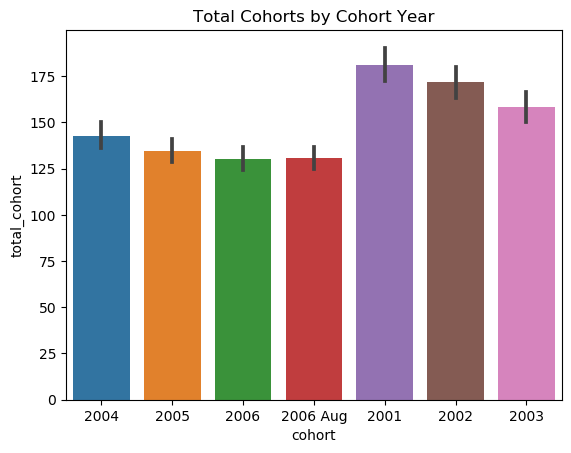

In [39]:
%matplotlib inline
sns.barplot(x='cohort', y='total_cohort', data=grd_df01_s05).set(title='Total Cohorts by Cohort Year')

[Text(0.5, 1.0, 'Total Grads by Cohort Year')]

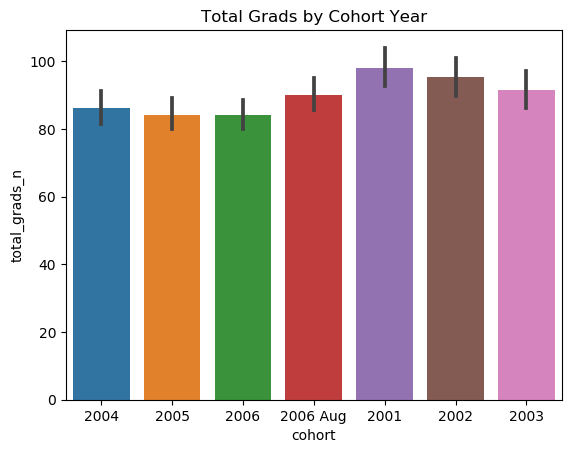

In [40]:
%matplotlib inline
sns.barplot(x='cohort', y='total_grads_n', data=grd_df01_s05).set(title='Total Grads by Cohort Year')

[Text(0.5, 1.0, 'Total Dropped Out by Cohort Year')]

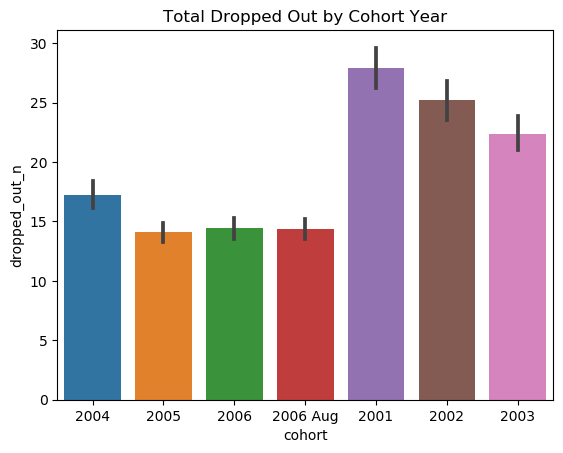

In [41]:
%matplotlib inline
sns.barplot(x='cohort', y='dropped_out_n', data=grd_df01_s05).set(title='Total Dropped Out by Cohort Year')

#### Display boxplots for select features

[Text(0.5, 1.0, 'Total Cohorts by Cohort Year')]

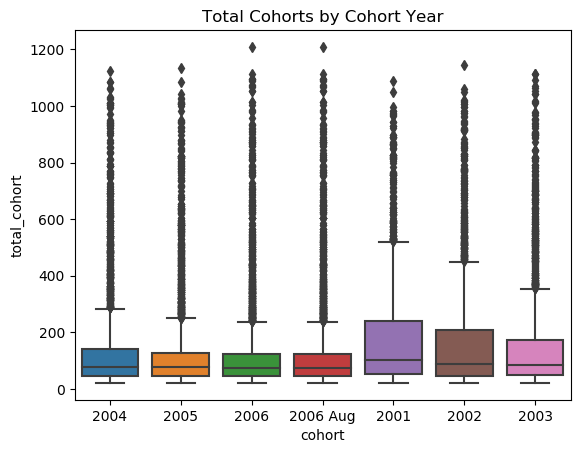

In [43]:
%matplotlib inline
sns.boxplot(x='cohort', y='total_cohort', data=grd_df01_s05).set(title='Total Cohorts by Cohort Year')

[Text(0.5, 1.0, 'Total Grads by Cohort Year')]

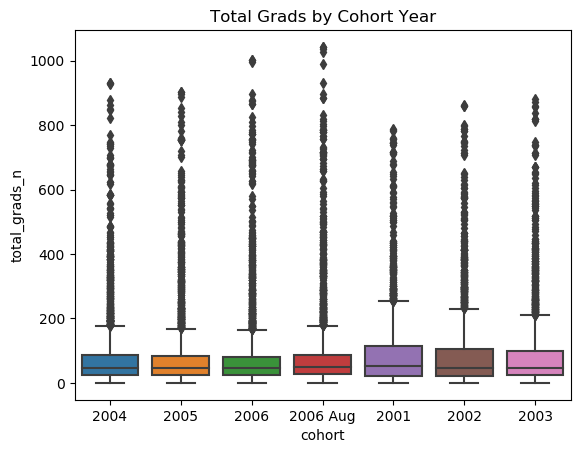

In [44]:
%matplotlib inline
sns.boxplot(x='cohort', y='total_grads_n', data=grd_df01_s05).set(title='Total Grads by Cohort Year')

[Text(0.5, 1.0, 'Total Dropped Out by Cohort Year')]

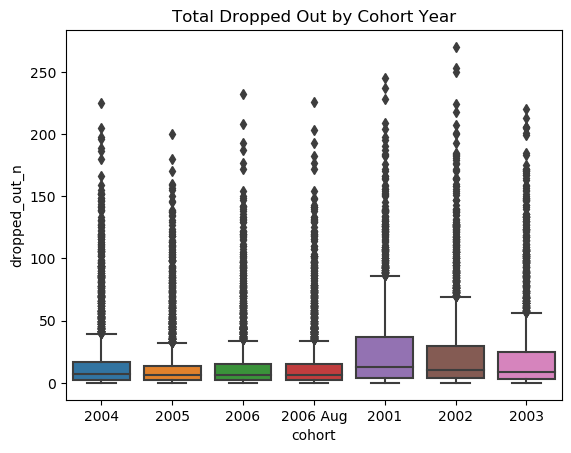

In [45]:
%matplotlib inline
sns.boxplot(x='cohort', y='dropped_out_n', data=grd_df01_s05).set(title='Total Dropped Out by Cohort Year')

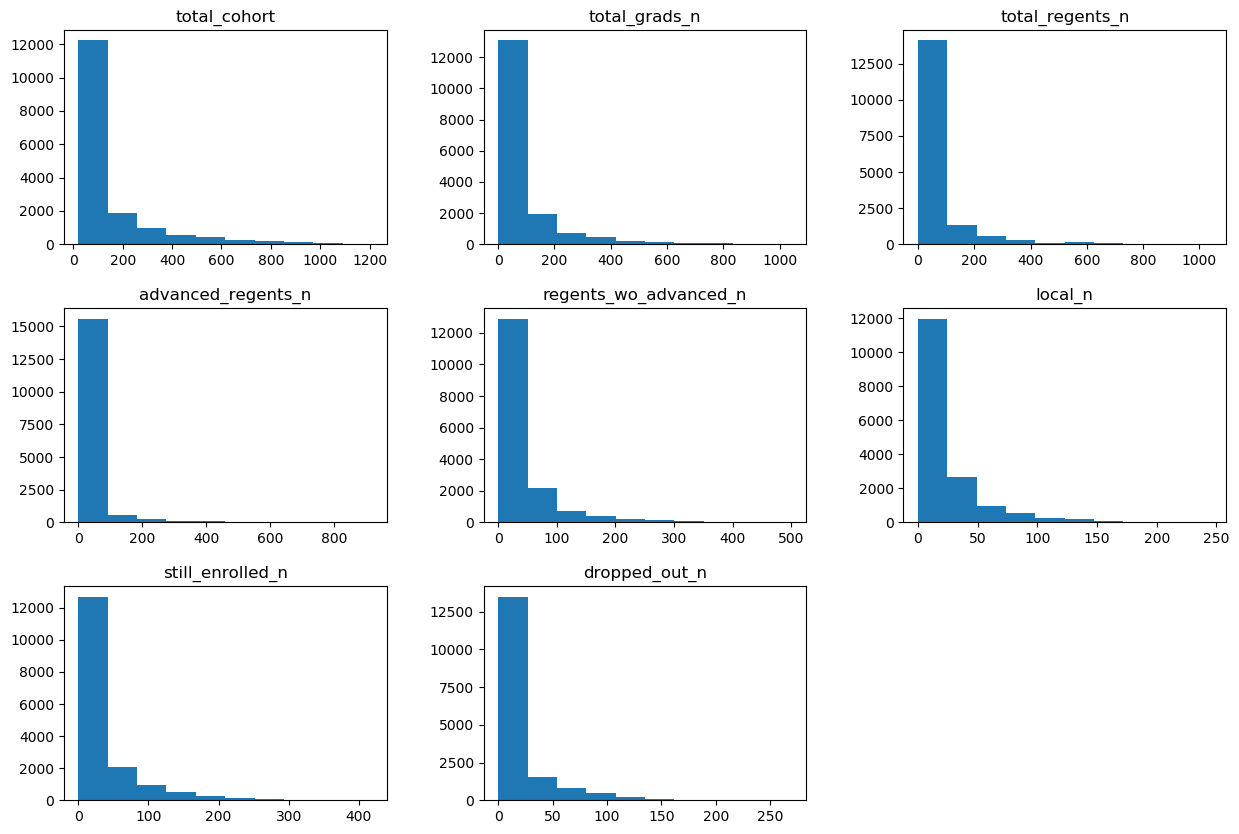

In [46]:
# histograms
grd_df01_s05.hist(grid=False, figsize=(15,10))
plt.show()

#### Create subsets of columns for various purposes

In [47]:
grd_df01_s05_num_lst01 = ['total_cohort',
                          'total_grads_n',
                          'total_regents_n',
                          'advanced_regents_n',
                          'regents_wo_advanced_n',
                          'local_n',
                          'still_enrolled_n',
                          'dropped_out_n'
                         ]

grd_df01_s05_num_lst02 = ['total_cohort',
                          'total_grads_n',
                          'total_regents_n',
                          'advanced_regents_n',
                          'regents_wo_advanced_n',
                          'local_n',
                          'still_enrolled_n',
                          'dropped_out_n'
                         ]

grd_df02_s01 = grd_df01_s05[grd_df01_s05_num_lst01]
grd_df03_s01 = grd_df01_s05[grd_df01_s05_num_lst02]

display(grd_df02_s01.head(5))

,total_cohort,total_grads_n,total_regents_n,advanced_regents_n,regents_wo_advanced_n,local_n,still_enrolled_n,dropped_out_n
0,55.0,37.0,17.0,0.0,17.0,20.0,15.0,3.0
1,64.0,43.0,27.0,0.0,27.0,16.0,9.0,9.0
2,78.0,43.0,36.0,0.0,36.0,7.0,16.0,11.0
3,78.0,44.0,37.0,0.0,37.0,7.0,15.0,11.0
4,64.0,46.0,32.0,7.0,25.0,14.0,10.0,6.0


#### Scatterplots of numerical features

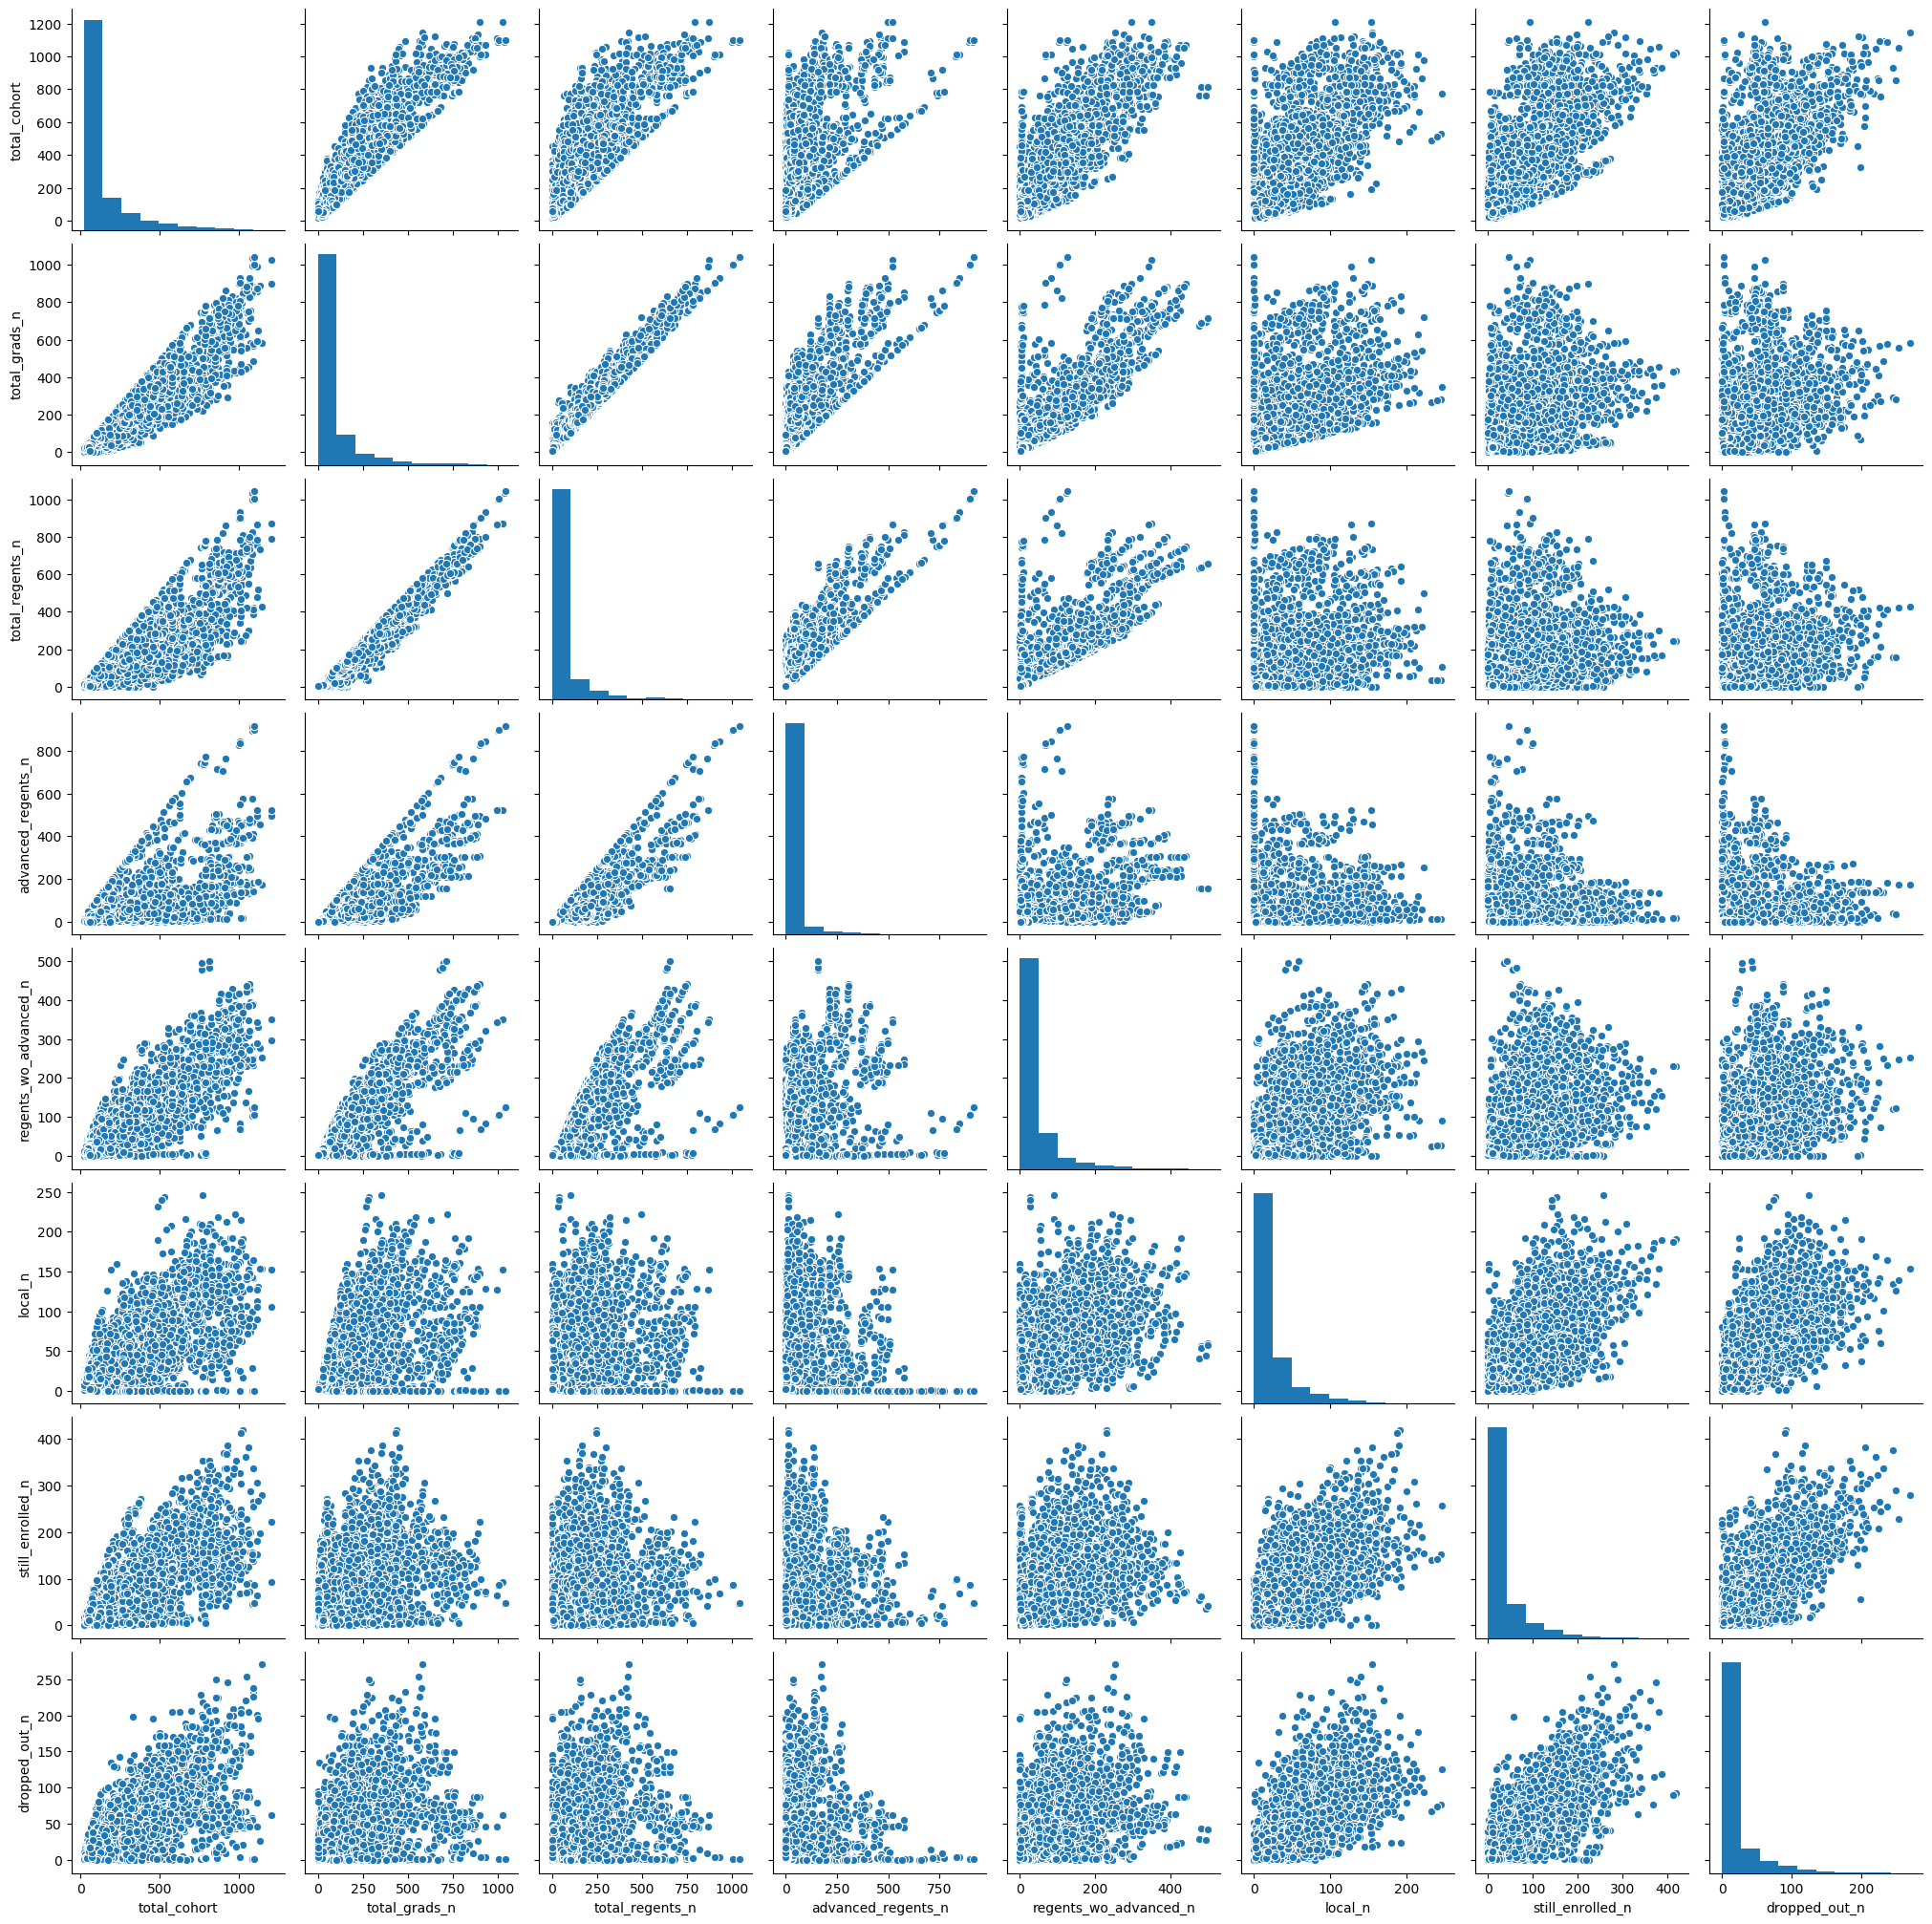

In [48]:
# Pair scatter plots for selected features
#sns.pairplot(grd_df02_s01.iloc[:, 0:2])
sns.pairplot(grd_df03_s01)

#### Summary stats for select features

In [49]:
sum_stat_totcohort = pd.DataFrame(grd_df01_s05['total_cohort'].describe()).T
sum_stat_totgrad = pd.DataFrame(grd_df01_s05['total_grads_n'].describe()).T
sum_stat_totdrop = pd.DataFrame(grd_df01_s05['dropped_out_n'].describe()).T
sum_stat_grad = pd.concat([sum_stat_totcohort, sum_stat_totgrad, sum_stat_totdrop])
sum_stat_grad

,count,mean,std,min,25%,50%,75%,max
total_cohort,16704.0,146.681454,179.345146,21.0,47.0,79.0,151.0,1209.0
total_grads_n,16704.0,89.159662,123.704706,0.0,25.0,48.0,93.0,1043.0
dropped_out_n,16704.0,18.447079,29.130904,0.0,3.0,7.0,19.0,270.0


#### Outliers for select features

In [50]:
# Total Cohort
IQR_totcohort = sum_stat_totcohort['75%'][0] - sum_stat_totcohort['25%'][0]
low_outlier_totcohort = sum_stat_totcohort['25%'][0] - 1.5*(IQR_totcohort)
high_outlier_totcohort = sum_stat_totcohort['75%'][0] + 1.5*(IQR_totcohort)
print('Low Outlier (total_cohort):', low_outlier_totcohort)
print('High Outlier (total_cohort):', high_outlier_totcohort)

# Total Grads
IQR_totgrad = sum_stat_totgrad['75%'][0] - sum_stat_totgrad['25%'][0]
low_outlier_totgrad = sum_stat_totgrad['25%'][0] - 1.5*(IQR_totgrad)
high_outlier_totgrad = sum_stat_totgrad['75%'][0] + 1.5*(IQR_totgrad)
print('Low Outlier (total_grads_n):', low_outlier_totgrad)
print('High Outlier (total_grads_n):', high_outlier_totgrad)

# Total Dropouts
IQR_totdrop = sum_stat_totdrop['75%'][0] - sum_stat_totdrop['25%'][0]
low_outlier_totdrop = sum_stat_totdrop['25%'][0] - 1.5*(IQR_totdrop)
high_outlier_totdrop = sum_stat_totdrop['75%'][0] + 1.5*(IQR_totdrop)
print('Low Outlier (dropped_out_n):', low_outlier_totdrop)
print('High Outlier (dropped_out_n):', high_outlier_totdrop)

Low Outlier (total_cohort): -109.0
High Outlier (total_cohort): 307.0
Low Outlier (total_grads_n): -77.0
High Outlier (total_grads_n): 195.0
Low Outlier (dropped_out_n): -21.0
High Outlier (dropped_out_n): 43.0


In [51]:
# Identify presence of outliers
outliers_totcohort = grd_df01_s05.loc[(grd_df01_s05['total_cohort'] < low_outlier_totcohort) | (grd_df01_s05['total_cohort'] > high_outlier_totcohort), 
                            ['dbn', 'total_cohort']]
if outliers_totcohort.empty:
    print('No outliers found in total_cohort column')
else:
    print('Outliers found in total_cohort column ({0}):'.format(len(outliers_totcohort)))
    print(outliers_totcohort)
    
outliers_totgrad = grd_df01_s05.loc[(grd_df01_s05['total_grads_n'] < low_outlier_totgrad) | (grd_df01_s05['total_grads_n'] > high_outlier_totgrad), 
                            ['dbn', 'total_grads_n']]
if outliers_totgrad.empty:
    print('No outliers found in total_grads_n column')
else:
    print('Outliers found in total_grads_n column ({0}):'.format(len(outliers_totgrad)))
    print(outliers_totgrad)
    
outliers_totdrop = grd_df01_s05.loc[(grd_df01_s05['dropped_out_n'] < low_outlier_totdrop) | (grd_df01_s05['dropped_out_n'] > high_outlier_totdrop), 
                            ['dbn', 'dropped_out_n']]
if outliers_totdrop.empty:
    print('No outliers found in dropped_out_n column')
else:
    print('Outliers found in dropped_out_n column ({0}):'.format(len(outliers_totdrop)))
    print(outliers_totdrop)

Outliers found in total_cohort column (2095):
          dbn  total_cohort
94     02M400         360.0
95     02M400         372.0
96     02M400         312.0
98     02M400         344.0
99     02M400         352.0
...       ...           ...
16644  31R460         364.0
16645  31R460         353.0
16646  31R460         458.0
16647  31R460         470.0
16648  31R460         470.0

[2095 rows x 2 columns]
Outliers found in total_grads_n column (1852):
          dbn  total_grads_n
94     02M400          271.0
95     02M400          276.0
96     02M400          228.0
97     02M400          236.0
98     02M400          241.0
...       ...            ...
16644  31R460          247.0
16645  31R460          227.0
16646  31R460          298.0
16647  31R460          328.0
16648  31R460          341.0

[1852 rows x 2 columns]
Outliers found in dropped_out_n column (2111):
          dbn  dropped_out_n
197    02M440          109.0
198    02M440           88.0
199    02M440           92.0
200    02M

#### Determine Skew for select features

In [52]:
# For 'total_cohort' column
totcohort_skew = skew(grd_df01_s05['total_cohort'])
print('Skewness of total_cohort column:', totcohort_skew)

# For 'total_grad' column
totgrad_skew = skew(grd_df01_s05['total_grads_n'])
print('Skewness of total_grads_n column:', totgrad_skew)

# For 'dropped_out_n' column
totdrop_skew = skew(grd_df01_s05['dropped_out_n'])
print('Skewness of dropped_out_n column:', totgrad_skew)

Skewness of total_cohort column: 2.6085451220516616
Skewness of total_grads_n column: 3.268921005914897
Skewness of dropped_out_n column: 3.268921005914897


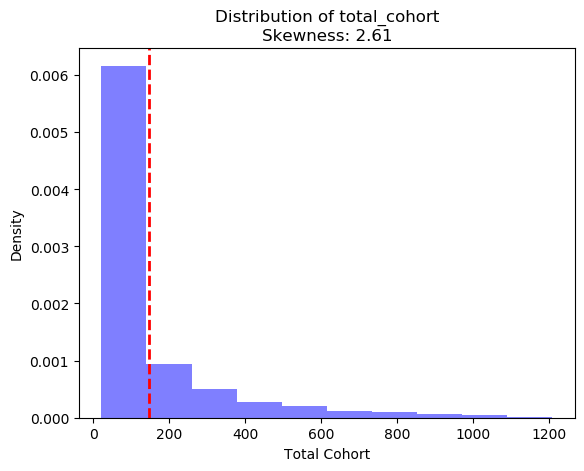

In [53]:
plt.hist(grd_df01_s05['total_cohort'], density=True, alpha=0.5, color='blue')
plt.title('Distribution of total_cohort\nSkewness: {0:.2f}'.format(totcohort_skew))
plt.xlabel('Total Cohort')
plt.ylabel('Density')
plt.axvline(x=grd_df01_s05['total_cohort'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

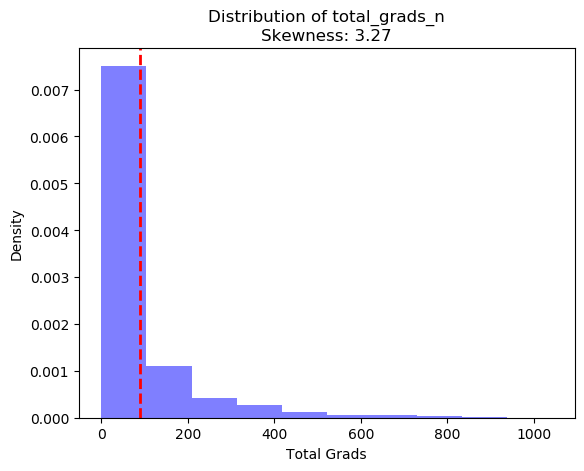

In [54]:
plt.hist(grd_df01_s05['total_grads_n'], density=True, alpha=0.5, color='blue')
plt.title('Distribution of total_grads_n\nSkewness: {0:.2f}'.format(totgrad_skew))
plt.xlabel('Total Grads')
plt.ylabel('Density')
plt.axvline(x=grd_df01_s05['total_grads_n'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

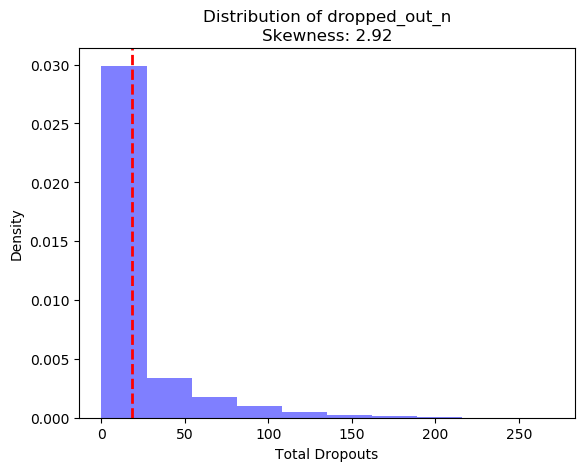

In [55]:
plt.hist(grd_df01_s05['dropped_out_n'], density=True, alpha=0.5, color='blue')
plt.title('Distribution of dropped_out_n\nSkewness: {0:.2f}'.format(totdrop_skew))
plt.xlabel('Total Dropouts')
plt.ylabel('Density')
plt.axvline(x=grd_df01_s05['dropped_out_n'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

#### Examine features with missing values

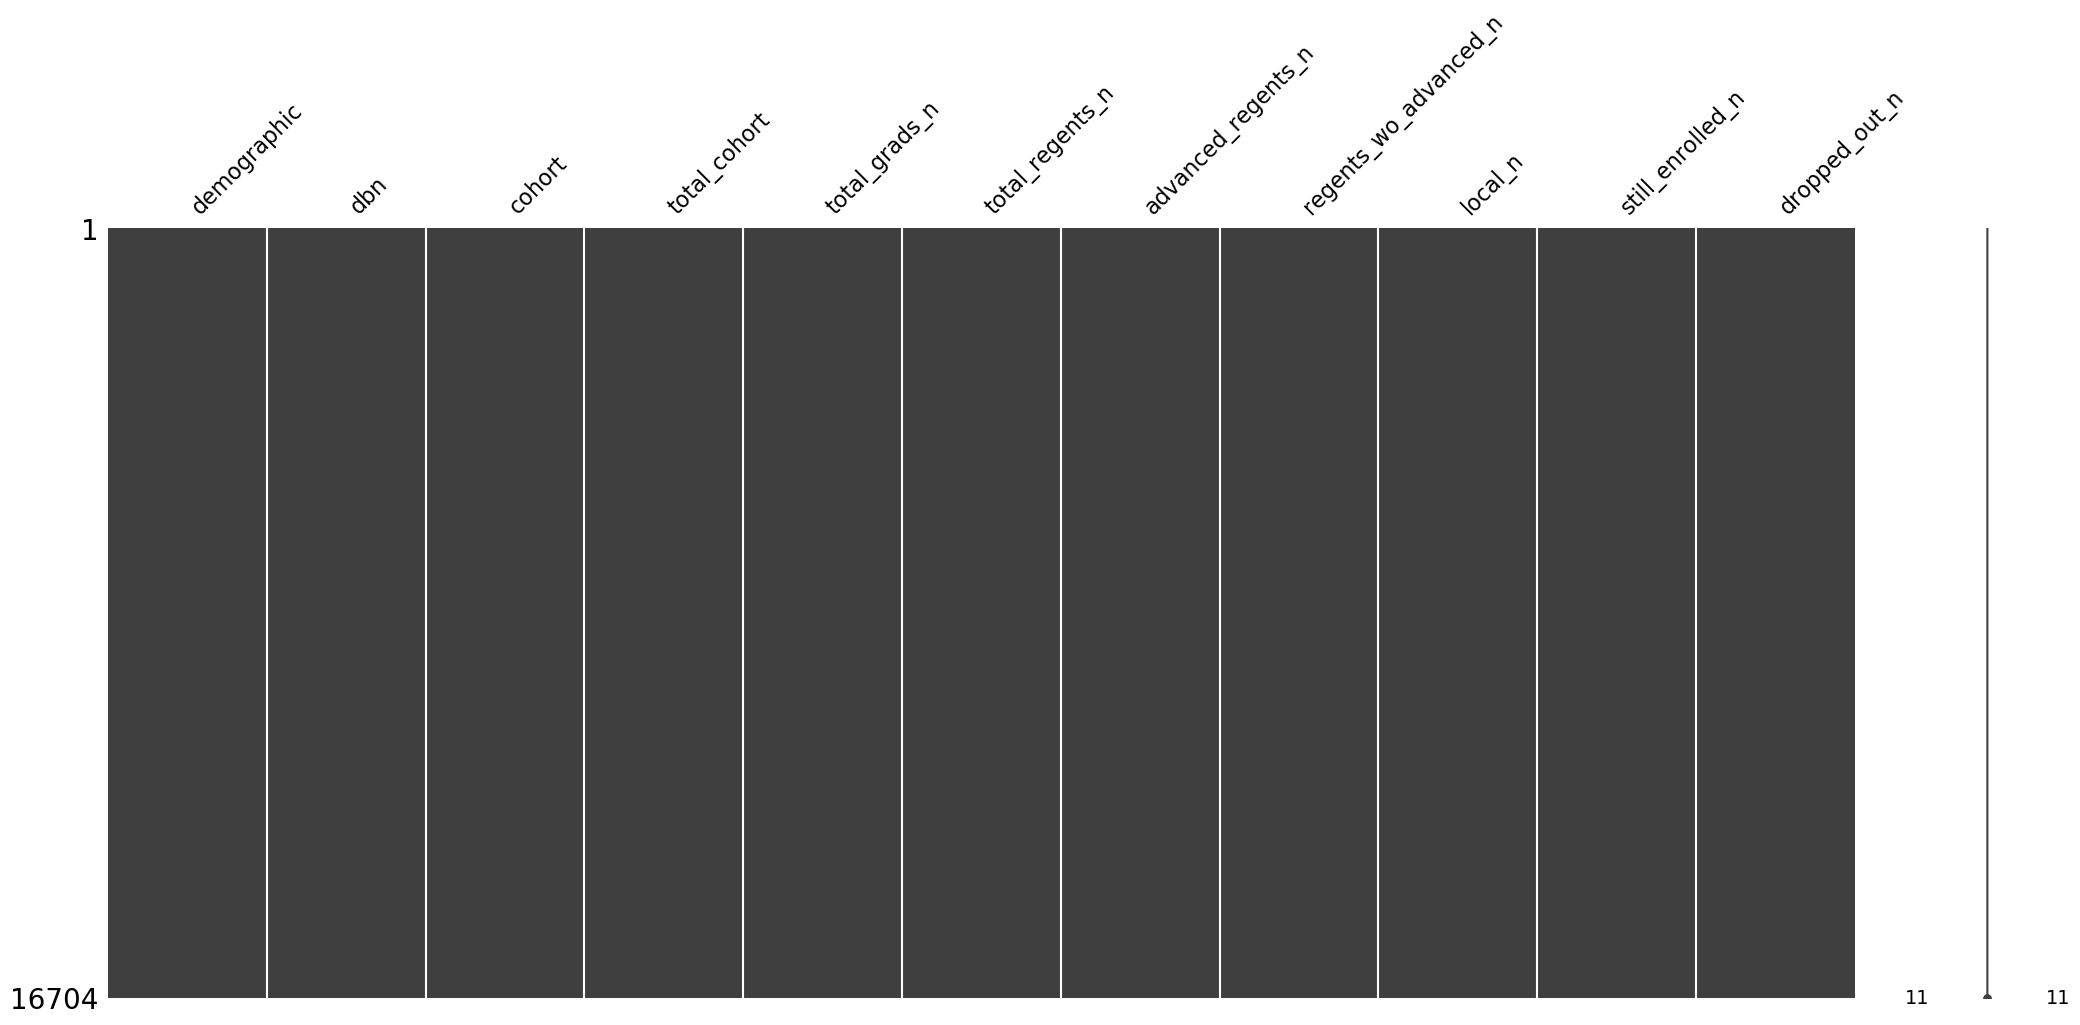

In [56]:
# Visualize missing values in each column
msno.matrix(grd_df01_s05)

In [57]:
# Remove any features for which the number of null vals exceed a threshold--
#-- (15% of total N)
grd_df01_s05_null_summ01 = pd.DataFrame(grd_df01_s05.isnull().sum(),
                                        columns=['null_count'])

grd_df01_s05_null_summ02 = grd_df01_s05_null_summ01.loc[(grd_df01_s05_null_summ01['null_count'] != 0)].sort_values('null_count',
                                                                                                                   ascending=False)
grd_df01_s05_null_summ03 = grd_df01_s05_null_summ02.reset_index()
print(grd_df01_s05_null_summ03)

grd_df01_s05_null_summ04 = grd_df01_s05_null_summ03.loc[grd_df01_s05_null_summ03['null_count'] > (len(grd_df01_s05)*.05)]
print('\n', grd_df01_s05_null_summ04)

grd_df01_s05_null_summ04_remove_lst01 = list(grd_df01_s05_null_summ04['index'])
print('\n', grd_df01_s05_null_summ04_remove_lst01)

#train_x03_tx_df01 = grd_df01_s05.drop(grd_df01_s05_null_summ04_remove_lst01, axis=1)
#test_x03_tx_df01 = test_x02_tx_df01_eda1.drop(grd_df01_s05_null_summ04_remove_lst01, axis=1)

#print(f'\n{train_x03_tx_df01.shape}')
#print(f'\n{test_x03_tx_df01.shape}')

Empty DataFrame
Columns: [index, null_count]
Index: []

 Empty DataFrame
Columns: [index, null_count]
Index: []

 []


#### Examine features with near zero variances

In [58]:
# Review near-zero variance (NZV) features for possible removal
grd_df02_s01_nzv_fit = VarianceThreshold().fit(grd_df02_s01)
grd_df02_s01_nzv_vc01 = grd_df02_s01_nzv_fit.transform(grd_df02_s01)
#print(grd_df02_s01_nzv_vc01)
#print(grd_df02_s01_nzv_vc01.shape)

# Get the names of the selected features
grd_df02_s01_nzv_fit_select_features = grd_df02_s01.columns[grd_df02_s01_nzv_fit.get_support()]

grd_df02_s01_nzv_df01 = pd.DataFrame(grd_df02_s01_nzv_vc01,
                                     columns=grd_df02_s01_nzv_fit_select_features)

display(grd_df02_s01_nzv_df01.head(5))
print(f'NZV transformed matrix dimensions = {grd_df02_s01_nzv_df01.shape}')

print(f'\n{grd_df02_s01.shape[1] - grd_df02_s01_nzv_df01.shape[1]} near zero variance features were eliminated')

,total_cohort,total_grads_n,total_regents_n,advanced_regents_n,regents_wo_advanced_n,local_n,still_enrolled_n,dropped_out_n
0,55.0,37.0,17.0,0.0,17.0,20.0,15.0,3.0
1,64.0,43.0,27.0,0.0,27.0,16.0,9.0,9.0
2,78.0,43.0,36.0,0.0,36.0,7.0,16.0,11.0
3,78.0,44.0,37.0,0.0,37.0,7.0,15.0,11.0
4,64.0,46.0,32.0,7.0,25.0,14.0,10.0,6.0


NZV transformed matrix dimensions = (16704, 8)

0 near zero variance features were eliminated


#### Correlations

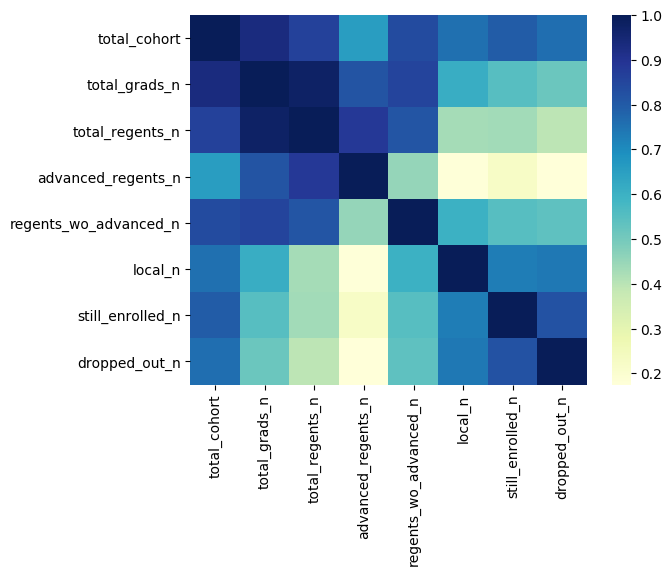

In [59]:
# Calculate correlation matrix
grad_corr_matrix = grd_df01_s05.corr()

# Generate heatmap plot
sns.heatmap(grad_corr_matrix, cmap="YlGnBu")